In [2]:
import os
import ee
import geemap
from geemap import cartoee
import cartopy.crs as ccrs # https://geemap.org/notebooks/51_cartoee_projections/
%pylab inline
ee.Initialize()

Populating the interactive namespace from numpy and matplotlib


In [3]:
roi = ee.Geometry.Polygon(
        [[[-81.25237281895075, 77.96375560277475],
          [-81.25237281895075, 59.338502878080575],
          [-39.943779068950754, 59.338502878080575],
          [-39.943779068950754, 77.96375560277475]]], None, False)
Map = geemap.Map()
Map.setCenter(-41.0, 74.0, 3)
Map


Map(center=[74.0, -41.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

In [4]:
Map.addLayer(roi, {}, 'roi')

In [5]:
# how to get corner coordinates: https://gis.stackexchange.com/questions/318959/get-lon-lat-of-a-top-left-corner-for-geometry-in-google-earth-engine
listCoords = ee.Array.cat(roi.coordinates(), 1); 

# get the X-coordinates
xCoords = listCoords.slice(1, 0, 1)
yCoords = listCoords.slice(1, 1, 2)

xMin = xCoords.reduce('min', [0]).get([0,0])
xMax = xCoords.reduce('max', [0]).get([0,0])
yMin = yCoords.reduce('min', [0]).get([0,0])
yMax = yCoords.reduce('max', [0]).get([0,0])

In [6]:
year_start = 2010 #  2002-07-04T00:00:00 - 2020-07-31T00:00:00
year_end = 2020
month_start = 1
month_end = 7

date_start = ee.Date.fromYMD(year_start, month_start, 1)
date_end = ee.Date.fromYMD(year_end, month_end, 31)
years = ee.List.sequence(year_start, year_end) # time range of years
months = ee.List.sequence(month_start, month_end)

In [7]:
dataset = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI') \
            .select(['Rrs_645', 'Rrs_555', 'Rrs_443']) \
            .filterBounds(roi) \
            .filterDate(date_start, date_end)

def funcY(y):
    def funcM(m):
        vi = dataset.filter(ee.Filter.calendarRange(y, y, 'year')) \
                    .filter(ee.Filter.calendarRange(m, m, 'month')) \
                    .median().clip(roi)
        return vi.set('year', y) \
                 .set('month', m) \
                 .set('system:time_start', ee.Date.fromYMD(y, m, 1).millis())
    return months.map(funcM)

seaColorMonthly = ee.ImageCollection.fromImages(years.map(funcY).flatten())

In [8]:
visParams = {
  'min': 0.0,
  'max': 0.011,
  'bands':['Rrs_645', 'Rrs_555', 'Rrs_443'],
}



In [9]:
firstImage = ee.Image(seaColorMonthly.first())
Map.addLayer(firstImage, visParams, 'First image')
# Map.add_colorbar(colors=visParams['palette'], vmin=visParams['min'], vmax=visParams['max'], caption="albedo")

In [10]:
region = [xMin.getInfo(), yMin.getInfo(), xMax.getInfo(), yMax.getInfo()]

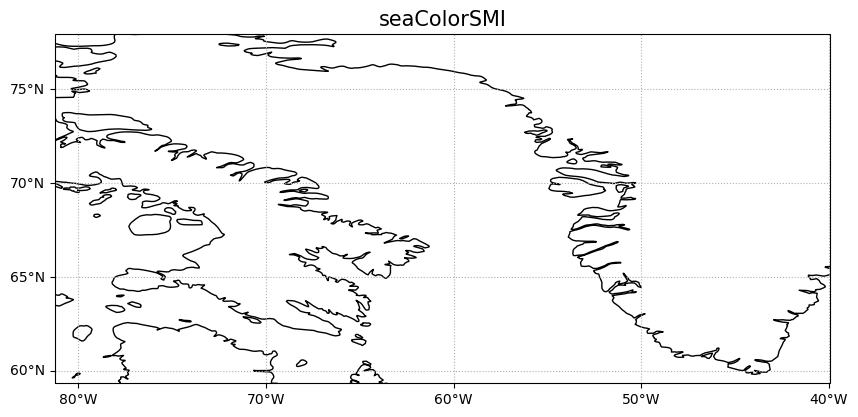

In [11]:
fig = plt.figure(figsize=(10, 8), dpi=100)

# use cartoee to get a map
# ax = cartoee.get_map(firstImage, region=region, vis_params=visParams, proj=ccrs.Mercator()) # change proj takes too long..
ax = cartoee.get_map(firstImage, region=region, vis_params=visParams)
ax.coastlines()
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[10, 5], linestyle=":")

# # add north arrow
# north_arrow_dict = {
#     "text": "N",
#     "xy": (0.1, 0.7),
#     "arrow_length": 0.2,
#     "text_color": "black",
#     "arrow_color": "black",
#     "fontsize": 20,
#     "width": 5,
#     "headwidth": 15,
#     "ha": "center",
#     "va": "center"
# }
# cartoee.add_north_arrow(ax, **north_arrow_dict)

# # add scale bar
# scale_bar_dict = {
#     "length": 100, 
#     "xy": (0.1, 0.05), 
#     "linewidth": 3,
#     "fontsize": 20,
#     "color": "black",
#     "unit": "km",
#     "ha": "center",
#     "va": "bottom"    
# }
# cartoee.add_scale_bar(ax, **scale_bar_dict)

ax.set_title(label = 'seaColorSMI', fontsize=15)

show()

In [11]:
cartoee.get_image_collection_gif(
    ee_ic = seaColorMonthly,
    out_dir = os.path.expanduser("~/Downloads/seaColorSMI"),
    out_gif = "seaColorSMI20102020.gif",
    vis_params = visParams,
    region = region,
    fps = 3,
    mp4 = True,
    grid_interval = (10, 5),
    plot_title = "Monthly Ocean Color SMI",
    date_format = 'YYYY-MM-dd',
    fig_size = (10, 8),
    dpi_plot = 100,
    file_format = "png",
    # proj=ccrs.Mercator(),
    # north_arrow_dict = north_arrow_dict,
    # scale_bar_dict = scale_bar_dict,
    verbose = True
)

GIF saved to C:\Users\au686295\Downloads\seaColorSMI\seaColorSMI20102020.gif
MP4 saved to C:\Users\au686295\Downloads\seaColorSMI\seaColorSMI20102020.mp4
